In [30]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import csv
import re
import matplotlib.pyplot as plt
import seaborn as sns
from bokeh.plotting import figure, output_file, show
from bokeh.palettes import Category20

In [31]:
import time
start_time = time.time()
# here your actual code/routine

In [32]:
url = "https://www.amazon.in/gp/bestsellers/books/ref=zg_bs_pg_"

# defining the User-Agent header to use in the GET request below
headers = {
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/107.0.0.0 Safari/537.36'
}

In [33]:
# Step 1: Send a GET request to the specified URL
page = requests.get(url, headers = headers)

In [34]:
# Step 2: Parse the HTML content of the response using BeautifulSoup
soup = BeautifulSoup(page.text, 'html.parser')

In [35]:
# initializing the variable that will contain
# the list of all quote data
books = []

In [44]:
# Scraping the data from a single page
def scrape_page(soup, books):
    book_elements = soup.find_all("div", class_="zg-grid-general-faceout")

    for book_element in book_elements:
        # Find the book author within the div tag with class
        book_author_element = book_element.find("div", class_="a-row a-size-small")
        # Find the book title within the div tag with class "_cDEzb_p13n-sc-css-line-clamp-1_1Fn1y"
        book_title_element = book_element.find("div", class_="_cDEzb_p13n-sc-css-line-clamp-1_1Fn1y")
        # Find the rating within the anchor tag"
        rating_element = book_element.find("a", title=True)
        # Find the price within the span tag with class "_cDEzb_p13n-sc-price_3mJ9Z"
        price_element = book_element.find("span", class_="_cDEzb_p13n-sc-price_3mJ9Z")
        # Find the customers rated within the anchor tag with class "a-size-small"
        customers_rated_element = book_element.find("div", class_="a-icon-row")

        # Check if all elements are found
        if all((book_author_element, book_title_element, rating_element, price_element, customers_rated_element)):
            # Extract text content if the elements exist
            book_author = book_author_element.find("div", class_="_cDEzb_p13n-sc-css-line-clamp-1_1Fn1y").text.strip()
            book_title = book_title_element.text.strip()
            rating = rating_element.get("title", "")
            price = price_element.text.strip()
            customers_rated = customers_rated_element.find("span", class_="a-size-small").text.strip()

            # Append the extracted data to the list of books
            books.append([book_author, book_title, rating, customers_rated, price])
        else:
            # Print a message if any of the elements are missing for a book
            print("Some elements are missing for a book.")

# Scraping the Data from Multiple pages
def scrape_multiple_pages(url):
    books = []

    # Start with the first page
    while True:
        # Send request to the page
        page = requests.get(url, headers=headers)
        soup = BeautifulSoup(page.text, 'html.parser')

        # Scrape data from the current page
        scrape_page(soup, books)

        # Check if there is a next page
        next_page_element = soup.find('li', class_='a-selected')
        if next_page_element:
            # Get the next page URL
            next_page_url = next_page_element.find_next_sibling('li', class_='a-last')
            if next_page_url and next_page_url.find('a'):
                # Construct the full URL for the next page
                url = "https://www.amazon.in" + next_page_url.find('a')['href']
                continue  # Continue to the next iteration of the loop
        break  # Break the loop if there is no next page

    return books

# Writing the Final result to a CSV FIle
def write_to_csv(books_data, file_name):
    with open(file_name, 'w', encoding='utf-8', newline='') as csv_file:
        writer = csv.writer(csv_file)
        writer.writerow(['Book_Author', 'Book_title', 'Rating', 'Customers_rated', 'Price'])
        writer.writerows(books_data)

url = "https://www.amazon.in/gp/bestsellers/books/ref=zg_bs_pg_"

# Scrape data from multiple pages
books_data = scrape_multiple_pages(url)

# Write data to CSV file
write_to_csv(books_data, 'Amazonbooks.csv')


Some elements are missing for a book.
Some elements are missing for a book.


In [45]:
# Read the CSV file and show the head
df = pd.read_csv('Amazonbooks_selenium.csv')

# Display the size of the CSV file (number of rows, number of columns)
print("Size of the CSV file:", df.shape)

# Display the head of the CSV file
print("Head of the CSV file:")
print(df.head())

Size of the CSV file: (58, 5)
Head of the CSV file:
         Book_Author                                         Book_title  \
0           BENYAMIN                                      AATUJEEVITHAM   
1  AKHIL P DHARMAJAN                                    RAM C/O ANANDHI   
2   Dr. Shiv K Sarin         Own Your Body: A Doctor's Life-saving Tips   
3        R.D. Sharma  Mathematics class 10th and MCQs - by R.D. Shar...   
4        James Clear  Atomic Habits: The life-changing million copy ...   

               Rating Customers_rated    Price  
0  4.7 out of 5 stars           3,019  ₹197.00  
1  4.4 out of 5 stars             365  ₹375.00  
2  4.6 out of 5 stars             124  ₹374.00  
3  4.4 out of 5 stars              34  ₹500.00  
4  4.6 out of 5 stars          91,801  ₹509.00  


In [43]:
# Define the function to clean book titles
def clean_book_title(title):
    # Remove any characters that are not letters, numbers, spaces, or hyphens
    cleaned_title = re.sub(r'[^a-zA-Z0-9\s\-]', '', title)
    # Remove extra spaces
    cleaned_title = ' '.join(cleaned_title.split())
    return cleaned_title

# Clean the 'Book_title' column
df['Book_title'] = df['Book_title'].apply(clean_book_title)

# Remove duplicate rows based on the 'Book_title' column
df = df.drop_duplicates(subset='Book_title', keep='first')

# Clean the 'Rating' column by removing ' out of 5 stars' and converting to float
df['Rating'] = df['Rating'].apply(lambda x: float(x.split()[0]) if isinstance(x, str) else x)

# Clean the 'Customers_rated' column by removing commas and converting to int
if df['Customers_rated'].dtype == 'object':
    df['Customers_rated'] = df['Customers_rated'].str.replace(',', '').astype(int)

# Convert 'Price' column to string, remove '₹' and commas, then convert to float
df['Price'] = df['Price'].astype(str).str.replace('₹', '').str.replace(',', '').astype(float)

# Display the DataFrame with the cleaned data
print(df)

                                          Book_Author  \
0                                            BENYAMIN   
1                                   AKHIL P DHARMAJAN   
2                                    Dr. Shiv K Sarin   
3                                         R.D. Sharma   
4                                         James Clear   
5                                     Daniel Kahneman   
6                                                  PW   
7                                       Morgan Housel   
8                                   Francesc Miralles   
9                          Chitra Banerjee Divakaruni   
10                                      Joseph Murphy   
11                                        Nimna Vijay   
12                                 Wonder House Books   
13                                      Joseph Nguyen   
14                             Oswaal Editorial Board   
15                                       M Laxmikanth   
16                             

Top 25 Highest Priced Books:
                                          Book_Author  \
50                          Manjit Kaur Lakhmir SIngh   
32                                        Seep Pahuja   
30                                MTG Editorial Board   
47                                    RAJ ENTERPRISES   
52                                        ARUN SHARMA   
15                                       M Laxmikanth   
34                      Veena Aggarwal, R S; Aggarwal   
21                                      Robert Greene   
44                             Oswaal Editorial Board   
4                                         James Clear   
6                                                  PW   
3                                         R.D. Sharma   
35                            Farah Sultan Aditya Raj   
5                                     Daniel Kahneman   
25                                     Vikram Sampath   
57  Sanubia & Rashmi Gupta Sonal Singh & Ruchi Kap...   
12

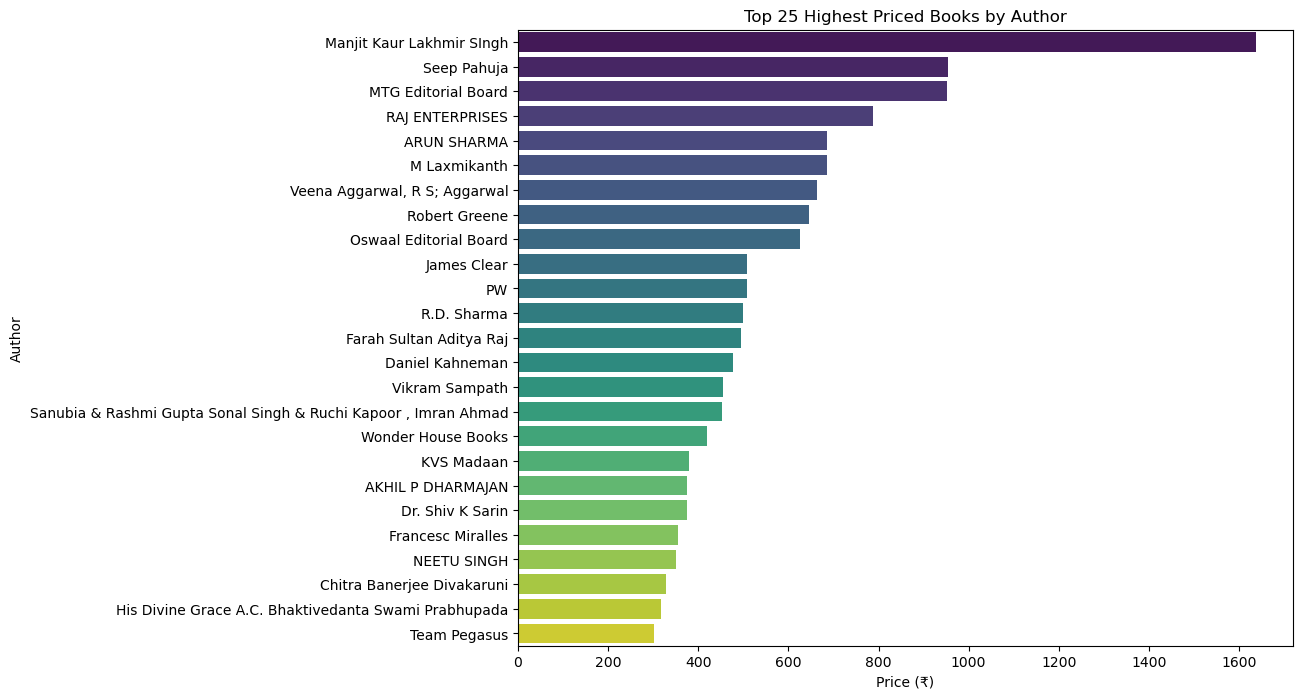


Top 25 Top Rated Books and Authors:
                                          Book_Author  \
25                                     Vikram Sampath   
33                                       Sunil Gurjar   
0                                            BENYAMIN   
17                                      Chetan Bhagat   
26  His Divine Grace A.C. Bhaktivedanta Swami Prab...   
42                                        Mitch Albom   
20  Deepali Pradeep Shrivastava , Sushil Singh , S...   
7                                       Morgan Housel   
8                                   Francesc Miralles   
46                                       Team Pegasus   
44                             Oswaal Editorial Board   
4                                         James Clear   
40                             Oswaal Editorial Board   
21                                      Robert Greene   
15                                       M Laxmikanth   
38                                       Team Pegas

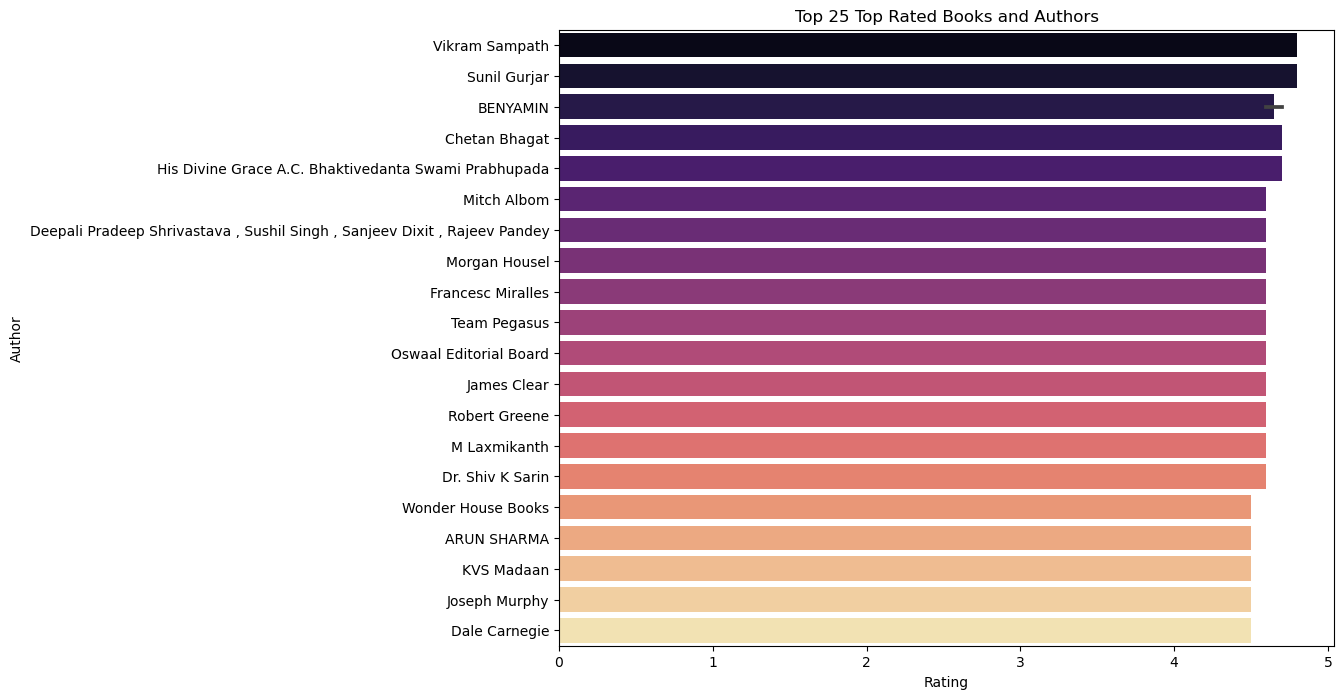


Top 15 Customer Rated Authors and Books:
                                          Book_Author  \
19                                   Alex Michaelides   
4                                         James Clear   
29                                      Dale Carnegie   
12                                 Wonder House Books   
10                                      Joseph Murphy   
7                                       Morgan Housel   
8                                   Francesc Miralles   
5                                     Daniel Kahneman   
22                                 Wonder House Books   
42                                        Mitch Albom   
21                                      Robert Greene   
49                                      Joseph Murphy   
37                                       Leil Lowndes   
56                                 Wonder House Books   
26  His Divine Grace A.C. Bhaktivedanta Swami Prab...   

                                           Bo

In [38]:
# Number 7
# the highest-priced book for each author
highest_priced_books = df.loc[df.groupby('Book_Author')['Price'].idxmax()]

# Sort the highest-priced books by price in descending order
highest_priced_books = highest_priced_books.sort_values(by='Price', ascending=False)

# Display the top 25 highest priced books as a DataFrame
print("Top 25 Highest Priced Books:")
print(highest_priced_books.head(25))

# Plot the top 25 highest priced books as a Bar diagram
plt.figure(figsize=(10, 8))
sns.barplot(x='Price', y='Book_Author', data=highest_priced_books.head(25), palette='viridis')
plt.title('Top 25 Highest Priced Books by Author')
plt.xlabel('Price (₹)')
plt.ylabel('Author')
plt.show()

# Number 8 
# top-rated books and authors based on customer ratings
top_rated_books = df.sort_values(by='Rating', ascending=False).head(25)

# Display the top-rated books and authors as a DataFrame
print("\nTop 25 Top Rated Books and Authors:")
print(top_rated_books)

# Plot the top-rated books and authors as a Bar diagram
plt.figure(figsize=(10, 8))
sns.barplot(x='Rating', y='Book_Author', data=top_rated_books, palette='magma')
plt.title('Top 25 Top Rated Books and Authors')
plt.xlabel('Rating')
plt.ylabel('Author')
plt.show()

# SNumber  9: 
# topmost customer-rated authors and books
top_customer_rated = df.sort_values(by='Customers_rated', ascending=False).head(15)

# Sort the topmost customer-rated authors and books in descending order by 'Customers_rated'
top_customer_rated = top_customer_rated.sort_values(by='Customers_rated', ascending=False)

# Display the topmost customer-rated authors and books as a DataFrame
print("\nTop 15 Customer Rated Authors and Books:")
print(top_customer_rated)

# Plot the topmost customer-rated authors and books using Bokeh
# Sort the DataFrame by 'Customers_rated' column in descending order
df_sorted = df.sort_values(by='Customers_rated', ascending=False)

# Drop duplicates based on the 'Book_Author' column
df_unique_authors = df_sorted.drop_duplicates(subset='Book_Author')

# Plot using Bokeh
from bokeh.plotting import figure, output_file, show

output_file("top_customer_rated_books_authors.html")

p = figure(y_range=df_unique_authors['Book_Author'], height=500, width=800, title="Top 15 Customer Rated Authors and Books",
           toolbar_location=None, tools="")

p.hbar(y=df_unique_authors['Book_Author'], right=df_unique_authors['Customers_rated'], height=0.8)

p.ygrid.grid_line_color = None
p.xaxis.axis_label = "Number of Customers Rated"
p.yaxis.axis_label = "Author"

show(p)


In [39]:
print("Process finished --- %s seconds ---" % (time.time() - start_time))

Process finished --- 7.162363290786743 seconds ---
